<font size=14><center><b>Simulation V2 (Périodicité mensuelle)</b></center></font>

# Imports

In [1]:
#pip install --user python-dateutil

In [2]:
from datetime import datetime

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sqlite3

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, scale
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# Fonctions

In [3]:
def CreationDir(dossier):
    """
    Crée le répertoire si il n'existe pas
    """
    if not os.path.exists(dossier):
        os.makedirs(dossier)


def reqSql(db,query):
    """
    Execute la requête SQL 'query' sur la
    database 'db' et renvoie le résultat
    """
    con = sqlite3.connect(db)
    df = pd.read_sql_query(query, con)
    con.close()
    return df


# Constantes

In [4]:
db = "dbs/olist.db"     # chemin de la database
dossierImage="images/"  # chemin ou déposer les images
CreationDir(dossierImage)
dossierDatas="datas/"   # chemin ou déposer les exports
CreationDir(dossierDatas)

# Récupération de la fenêtre des dates de commandes

In [5]:
query="SELECT min(order_purchase_timestamp) as date_debut, \
        max(order_purchase_timestamp) as date_fin from orders"
dfDates = reqSql(db,query)
dfDates.head()

,date_debut,date_fin
0,2016-09-04 21:15:19,2018-10-17 17:30:18


# Récuperation informations de temporalité

## Définition des bornages
> Par mois

In [6]:
import calendar

def mois(M,Y):
    """
    Fonction pour renvoyer le premier et dernier jour du mois
    en fonction de l'année et du numéro de mois
    """
    premier, dernier = calendar.monthrange(Y,M)
    if M < 10 : M=f'0{M}'
    if premier < 10 : premier=f'0{premier}'
    deb = f'{Y}-{M}-{premier}'
    fin = f'{Y}-{M}-{dernier}'
    return [f'{Y}_{M}', deb, fin]

In [7]:
from dateutil.relativedelta import relativedelta

date_debut = datetime.fromisoformat(dfDates.iloc[0,0].split(' ')[0])
date_fin = datetime.fromisoformat(dfDates.iloc[0,1].split(' ')[0])
date_temp = date_debut

temporalite = []
while date_temp < date_fin :
    date_after_month = date_temp + relativedelta(months = 1)
    retour = mois(date_temp.month,date_temp.year)
    temporalite.append(retour)
    date_temp = date_after_month

## Fonction nettoyage des données

In [8]:
def cleanEngine(df,current_date):
    df['montant_min'] = df['montant_min'].fillna(0)
    df['montant_moy'] = df['montant_moy'].fillna(0)
    df['montant_max'] = df['montant_max'].fillna(0)
    df['montant_tot'] = df['montant_tot'].fillna(0)
    df['review_min'] = df['review_min'].fillna(0)
    df['review_moy'] = df['review_moy'].fillna(0)
    df['review_max'] = df['review_max'].fillna(0)
    # conversion en datetime
    df['order_last'] = pd.to_datetime(df['order_last'])
    df['order_first'] = pd.to_datetime(df['order_first'])
    # calcul du delta nb jours
    df['R'] = (datetime.fromisoformat(current_date)-df['order_last']).dt.days
    # récupération nb commandes
    df['F'] = df['nb_order']
    # récupération montant total et arrondi
    df['M'] = round(df['montant_moy'])
    df = df.astype({'M':'int'})
    return df

## Fonction récuperation des données de la base

In [9]:
def getCustomersFromDate(periode,date_fin,date_deb='2016-09-04'):
    query=f"""
    SELECT
        cst.customer_unique_id as id_uniq_custom,
        round(min(itms.price),2) as montant_min,
        round(max(itms.price),2) as montant_max,
        round(avg(itms.price),2) as montant_moy,
        round(sum(itms.price),2) as montant_tot,
        count(distinct ord.order_id) as nb_order,
        count(distinct itms.order_item_id) as max_nb_articles,
        min(rev.review_score) as review_min,
        round(avg(rev.review_score),1) as review_moy,
        max(rev.review_score) as review_max,
        min(ord.order_purchase_timestamp) as order_first,
        avg(ord.order_purchase_timestamp) as order_moy,
        max(ord.order_purchase_timestamp) as order_last,
        geo.geolocation_lat as lat,
        geo.geolocation_lng as lng,
        cast(min(julianday(order_delivered_customer_date) \
        - julianday(order_estimated_delivery_date)) as integer) as retard_min,
        cast(avg(julianday(order_delivered_customer_date) \
        - julianday(order_estimated_delivery_date)) as integer) as retard_moy,
        cast(max(julianday(order_delivered_customer_date) \
        - julianday(order_estimated_delivery_date)) as integer) as retard_max,
        cast(min(julianday(order_delivered_customer_date) \
        - julianday(order_purchase_timestamp)) as integer) as livraison_min,
        cast(avg(julianday(order_delivered_customer_date) \
        - julianday(order_purchase_timestamp)) as integer) as livraison_moy,
        cast(max(julianday(order_delivered_customer_date) \
        - julianday(order_purchase_timestamp)) as integer) as livraison_max,
        cast(avg(julianday(order_estimated_delivery_date) \
        - julianday(order_purchase_timestamp)) as integer) as estimation_moy
    from
        customers as cst,
        orders as ord
    LEFT OUTER JOIN
        order_reviews as rev ON ord.order_id = rev.order_id
    LEFT OUTER JOIN
        geoloc as geo ON cst.customer_zip_code_prefix \
        = geo.geolocation_zip_code_prefix
    LEFT OUTER JOIN
        order_items as itms ON ord.order_id = itms.order_id
    /*LEFT OUTER JOIN
        products as prd ON itms.product_id = prd.product_id 
    */
    where
        ord.customer_id = cst.customer_id
    /*    not ord.order_status = 'canceled' */
        and ord.order_purchase_timestamp >= '{date_deb}'
        and ord.order_purchase_timestamp <= '{date_fin}'
    group by
        cst.customer_unique_id
    order by
        nb_order DESC
    """
    print(f'      Création dataFrame df{periode} avec données \
            du {date_deb} au {date_fin}')
    globals()[f'df{periode}'] = cleanEngine(reqSql(db,query),date_fin)

## Création des DataFrames

In [10]:
for periode in temporalite :
        print(f'   Période {periode[0]} :')
        getCustomersFromDate(periode[0],date_fin=periode[2])

   Période 2016_09 :
      Création dataFrame df2016_09 avec données             du 2016-09-04 au 2016-09-30
   Période 2016_10 :
      Création dataFrame df2016_10 avec données             du 2016-09-04 au 2016-10-31
   Période 2016_11 :
      Création dataFrame df2016_11 avec données             du 2016-09-04 au 2016-11-30
   Période 2016_12 :
      Création dataFrame df2016_12 avec données             du 2016-09-04 au 2016-12-31
   Période 2017_01 :
      Création dataFrame df2017_01 avec données             du 2016-09-04 au 2017-01-31
   Période 2017_02 :
      Création dataFrame df2017_02 avec données             du 2016-09-04 au 2017-02-28
   Période 2017_03 :
      Création dataFrame df2017_03 avec données             du 2016-09-04 au 2017-03-31
   Période 2017_04 :
      Création dataFrame df2017_04 avec données             du 2016-09-04 au 2017-04-30
   Période 2017_05 :
      Création dataFrame df2017_05 avec données             du 2016-09-04 au 2017-05-31
   Période 2017_06 

In [11]:
del df2016_09

In [12]:
userList = df2016_10['id_uniq_custom']
userList

0      f7b62c75467e8ce080b201667cbbc274
1      7a176e5d88c7acb6000a055e008c055d
2      0ecf7f65b5ff3b9e61b637e59f495e0a
3      ffb973f2bb1c0cb807a99341a9b20dcd
4      ff8557b296729eaa30f078d974c86812
                     ...               
320    0313291a6f4f16df04dcf819d88c38ef
321    01f156677184504063bd19739f924af1
322    00f0b70fdcb8a6e1671b52a2472bd41f
323    009b0127b727ab0ba422f6d9604487c7
324    0032c76b20340da25249092a268ce66c
Name: id_uniq_custom, Length: 325, dtype: object

# Mise aux normes des dataFrames

In [13]:
def GetUsersInDf(df,userList):
    """
    *   Filtre les individus qui ne sont pas dans userList du dataframe donné
    """
    index2Del = globals()[f'{df}'][globals()[f'{df}']['id_uniq_custom']\
                        .isin(userList) == False].index
    print(f'{len(index2Del)} individus doivent être éffacés de {df}')
    globals()[f'{df}'].drop(index2Del, inplace=True)
    restants = len(globals()[f'{df}'])
    print(f'{restants} individus restants dans {df}')

all_df = %who_ls DataFrame
for dfId in all_df:
    if dfId.startswith('df20'):
        GetUsersInDf(dfId,userList)

0 individus doivent être éffacés de df2016_10
325 individus restants dans df2016_10
0 individus doivent être éffacés de df2016_11
325 individus restants dans df2016_11
1 individus doivent être éffacés de df2016_12
325 individus restants dans df2016_12
698 individus doivent être éffacés de df2017_01
325 individus restants dans df2017_01
2463 individus doivent être éffacés de df2017_02
325 individus restants dans df2017_02
5083 individus doivent être éffacés de df2017_03
325 individus restants dans df2017_03
7437 individus doivent être éffacés de df2017_04
325 individus restants dans df2017_04
10974 individus doivent être éffacés de df2017_05
325 individus restants dans df2017_05
14146 individus doivent être éffacés de df2017_06
325 individus restants dans df2017_06
17993 individus doivent être éffacés de df2017_07
325 individus restants dans df2017_07
22172 individus doivent être éffacés de df2017_08
325 individus restants dans df2017_08
26341 individus doivent être éffacés de df2017_09

In [14]:
df2018_10

,id_uniq_custom,montant_min,montant_max,montant_moy,montant_tot,nb_order,max_nb_articles,review_min,review_moy,review_max,...,retard_min,retard_moy,retard_max,livraison_min,livraison_moy,livraison_max,estimation_moy,R,F,M
219,32ea3bdedab835c3aa6cb68ce66565ef,25.99,49.00,34.96,4720.05,3,1,4.0,4.7,5.0,...,-11.0,-6.0,0.0,5.0,12.0,23.0,18,124,3,35
327,f7b62c75467e8ce080b201667cbbc274,30.97,59.90,54.93,41252.93,2,2,1.0,1.5,4.0,...,-45.0,-18.0,-12.0,7.0,36.0,42.0,54,753,2,55
784,ccafc1c3f270410521c3c6f3b249870f,41.99,132.40,87.20,6103.65,2,1,5.0,5.0,5.0,...,-42.0,-27.0,-12.0,13.0,15.0,17.0,43,145,2,87
1360,94e5ea5a8c1bf546db2739673060c43f,54.90,97.88,76.39,5194.52,2,1,5.0,5.0,5.0,...,-28.0,-20.0,-13.0,5.0,15.0,25.0,36,174,2,76
1502,87b3f231705783eb2217e25851c0a45d,191.40,239.90,215.65,156130.60,2,1,2.0,3.5,5.0,...,-44.0,-28.0,-13.0,7.0,9.0,11.0,38,179,2,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94961,0313291a6f4f16df04dcf819d88c38ef,95.00,95.00,95.00,16245.00,1,1,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,81,751,1,95
95378,01f156677184504063bd19739f924af1,739.98,739.98,739.98,18499.50,1,1,5.0,5.0,5.0,...,-45.0,-45.0,-45.0,7.0,7.0,7.0,52,750,1,740
95729,00f0b70fdcb8a6e1671b52a2472bd41f,0.00,0.00,0.00,0.00,1,0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,42,756,1,0
95861,009b0127b727ab0ba422f6d9604487c7,0.00,0.00,0.00,0.00,1,0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,16,777,1,0


# Préparation et Fit du modèle

In [15]:
# Chargement des données
df = pd.read_csv(dossierDatas+'df.csv',
                 sep='|',
                 lineterminator='\n',
                 encoding='utf-8')

In [16]:
def preProcessingData(dfIn):
    df = pd.DataFrame(globals()[f'{dfIn}'][['R', 'F', 'M']])
    # on supprime les clients avec un montant moyen = 0
    index2Del=df.loc[df['M']==0].index
    #df.drop(index2Del, inplace=True)
    # on limite le nombre de commandes a 5
    df.loc[df['F']>5,'F']=5
    # application du log et du minMaxScaler
    df['M'] = MinMaxScaler().fit_transform(np.log1p(df[['M']]))
    df['F'] = MinMaxScaler().fit_transform(np.log1p(df[['F']]))
    df['R'] = MinMaxScaler().fit_transform(df[['R']])
    #print(f'dataFrame {dfIn} : {df.shape[0]} individus et {df.shape[1]} variables')
    return df

In [17]:
dfModele = preProcessingData('df')

In [18]:
variableIn = dfModele
initialisation_modele = 'k-means++'
random_state = 42
n_init = 1
nbCluster=6

In [19]:
modele = KMeans(nbCluster,
                n_init=n_init,
                init=initialisation_modele,
                random_state=random_state).fit(variableIn)

# Calcul de l'ARI pour chaque mois

In [20]:
from sklearn.metrics.cluster import adjusted_rand_score

def graphMod(df,resultMod):
    global nbCluster
    annee, mois = str(df[2:]).split('_')
    colorGroup = sns.color_palette("hls", nbCluster)
    colorsG = []
    for groupe in resultMod :
        colorsG.append(colorGroup[groupe])
    titre = f"Kmeans - Clasification RFM 3d du {mois}-{annee}"
    df = preProcessingData(df)
    f = plt.figure(figsize = (6,6))
    f.set_figwidth=20
    f.set_figheight=20
    ax = f.add_subplot(projection='3d')
    x = df['R']
    y = df['M']
    z = df['F']
    plt.title(titre, fontsize=14, pad=15)
    ax.set_xlim(1,0)
    #ax.set_zlim(0,1)
    #ax.set_ylim(0,1)
    scoreE = ax.scatter(x, y, z, color=colorsG, s=4, alpha=0.2)
    ax.set_xlabel('Récence')
    ax.set_ylabel('Montant moyen')
    ax.set_zlabel('Nombre de commandes')
    #ax.zaxis.labelpad=0.2
    ax.set_facecolor('white')
    plt.savefig(dossierImage+titre+'.jpg')
    plt.show()

def getARI(modele, dfIdPrec, dfId):
    print(f'{dfIdPrec} --> {dfId}')
    resultMod1 = modele.predict(preProcessingData(dfIdPrec))
    resultMod2 = modele.predict(preProcessingData(dfId))
    ARI = adjusted_rand_score(resultMod1, resultMod2)
    print(f'Score ARI : {ARI}')
    graphMod(dfId,resultMod2)
    dfRetour = pd.DataFrame({"Periode":[dfId[2:]], "ARI":[ARI]})
    return dfRetour

df2016_10 --> df2016_11
Score ARI : 1.0


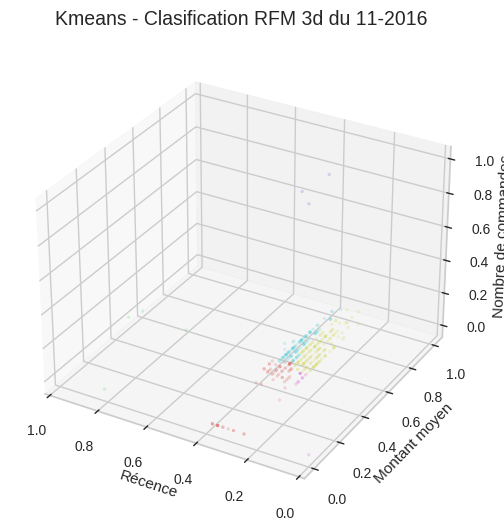

df2016_11 --> df2016_12
Score ARI : 1.0


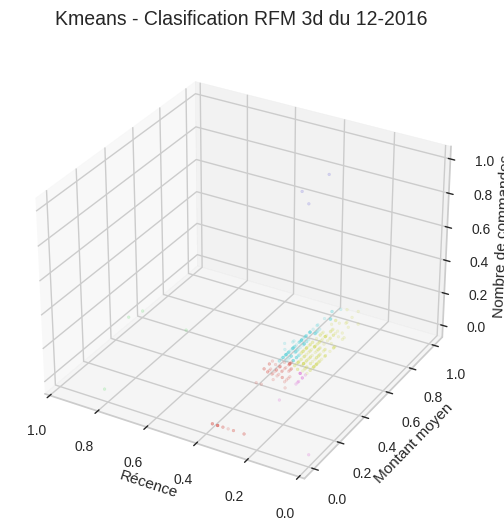

df2016_12 --> df2017_01
Score ARI : 1.0


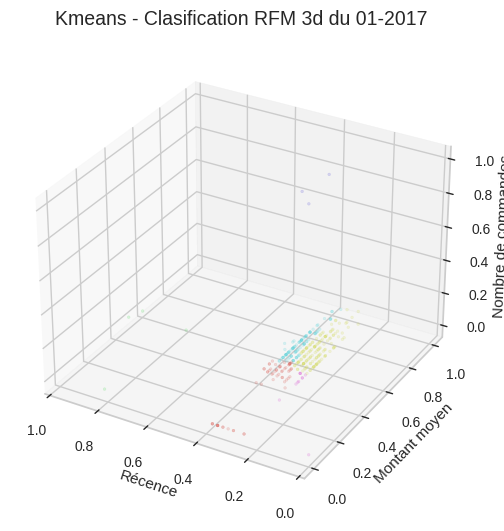

df2017_01 --> df2017_02
Score ARI : 1.0


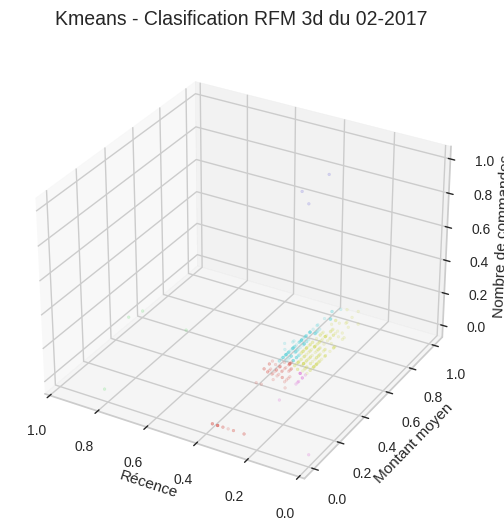

df2017_02 --> df2017_03
Score ARI : 1.0


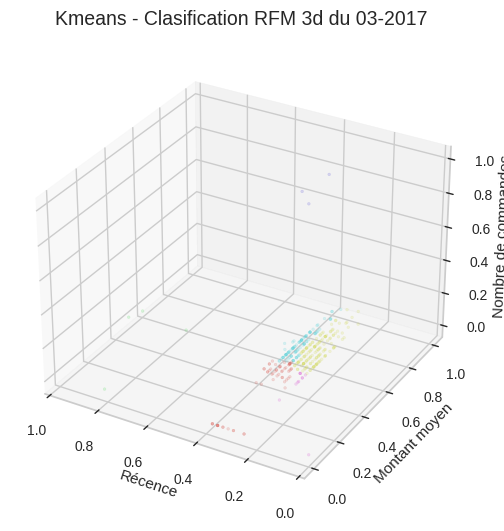

df2017_03 --> df2017_04
Score ARI : 0.01610074602534554


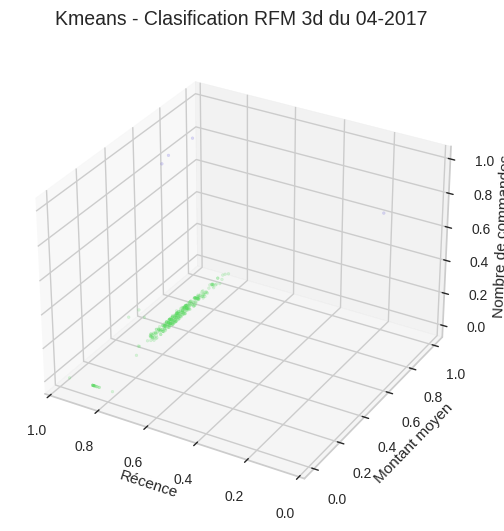

df2017_04 --> df2017_05
Score ARI : 1.0


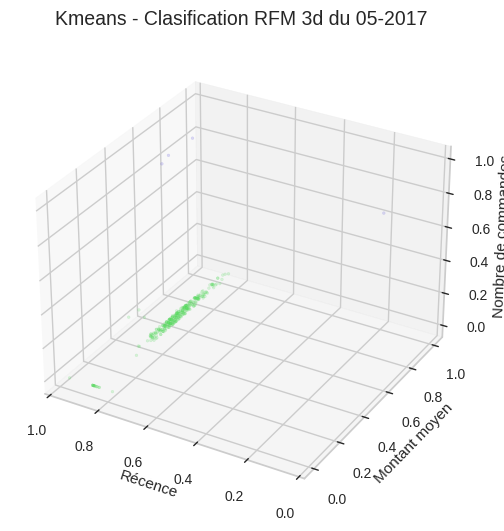

df2017_05 --> df2017_06
Score ARI : 1.0


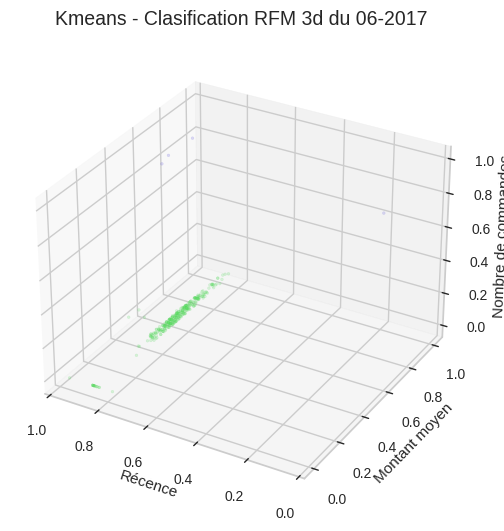

df2017_06 --> df2017_07
Score ARI : 0.8845315019311762


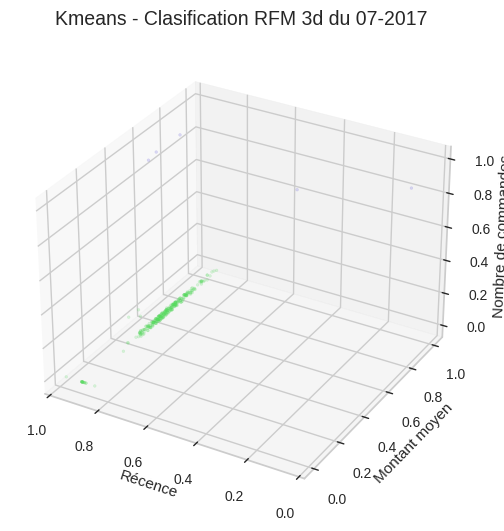

df2017_07 --> df2017_08
Score ARI : 1.0


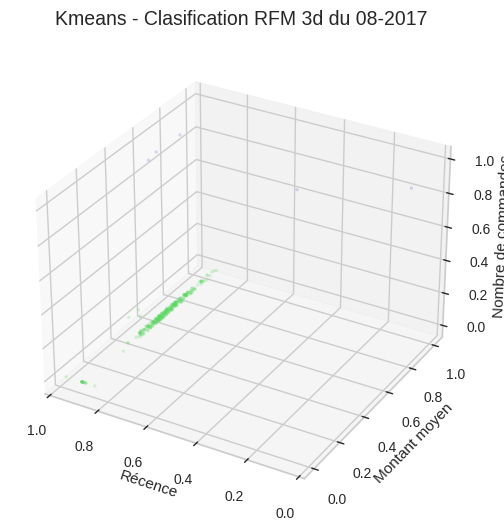

df2017_08 --> df2017_09
Score ARI : 0.9046405194779059


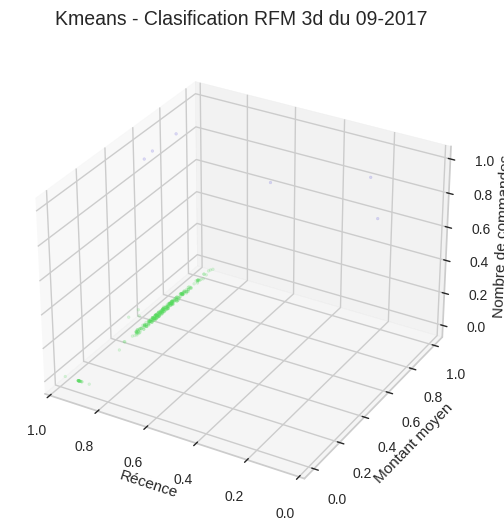

df2017_09 --> df2017_10
Score ARI : 1.0


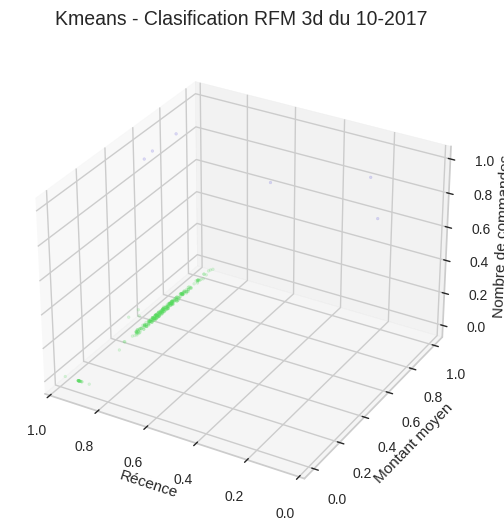

df2017_10 --> df2017_11
Score ARI : 0.9185552140132127


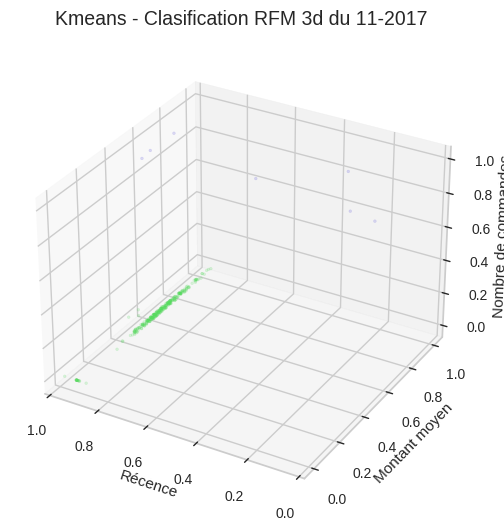

df2017_11 --> df2017_12
Score ARI : 1.0


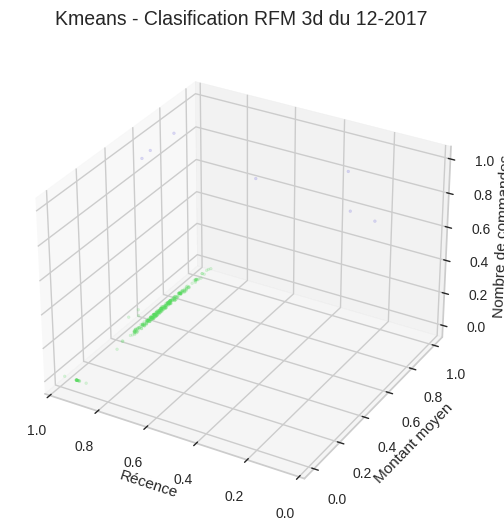

df2017_12 --> df2018_01
Score ARI : 0.9287529998242319


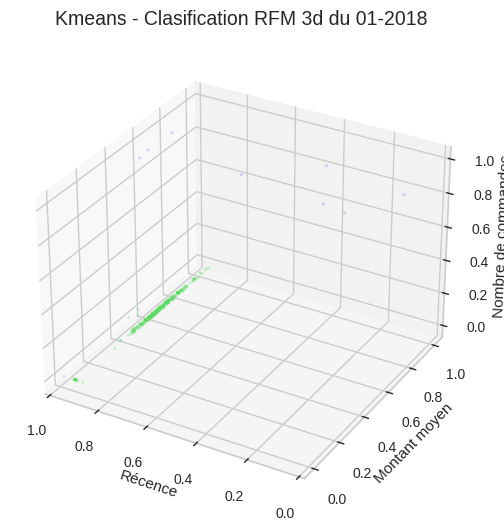

df2018_01 --> df2018_02
Score ARI : 1.0


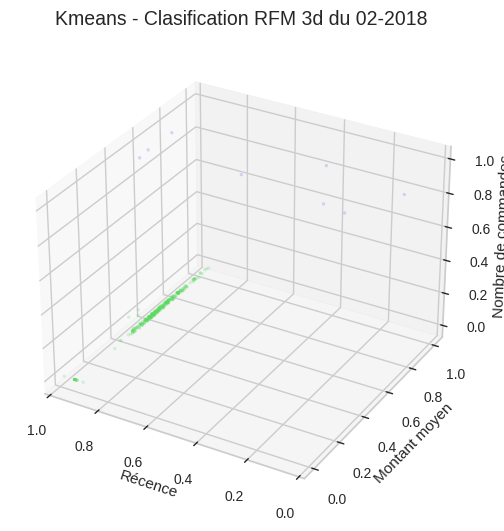

df2018_02 --> df2018_03
Score ARI : 0.9365455552963604


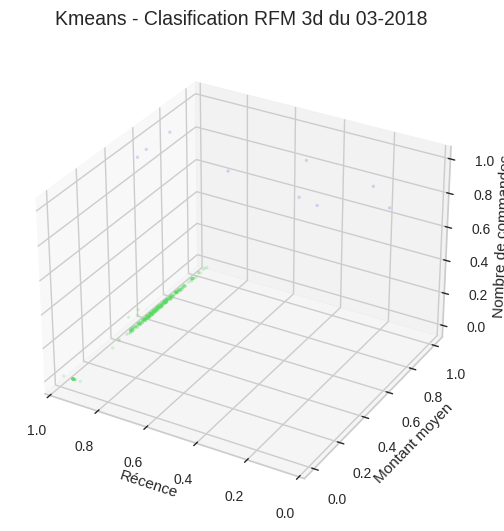

df2018_03 --> df2018_04
Score ARI : 1.0


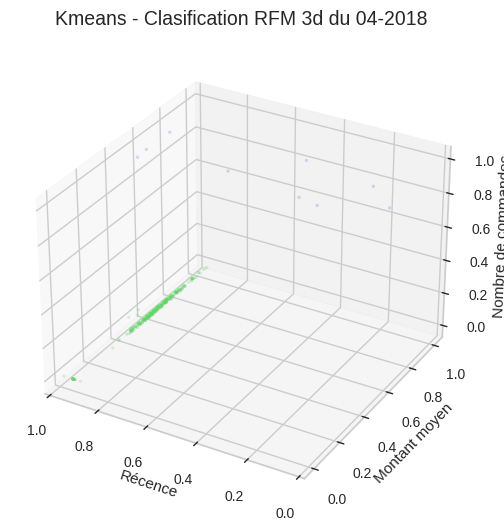

df2018_04 --> df2018_05
Score ARI : 0.8909677022508588


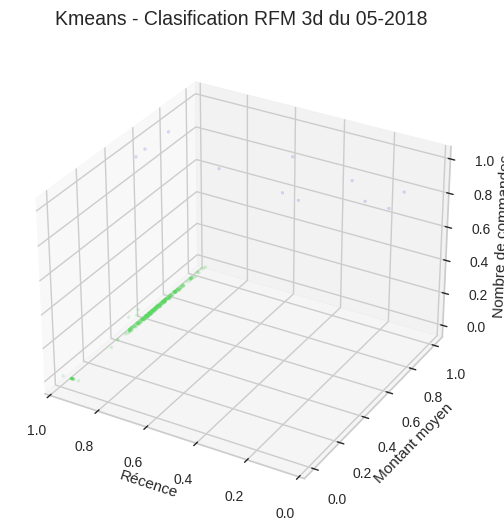

df2018_05 --> df2018_06
Score ARI : 0.7832856496750814


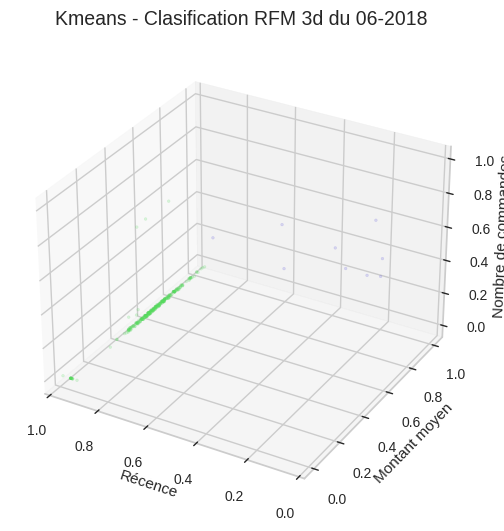

df2018_06 --> df2018_07
Score ARI : 1.0


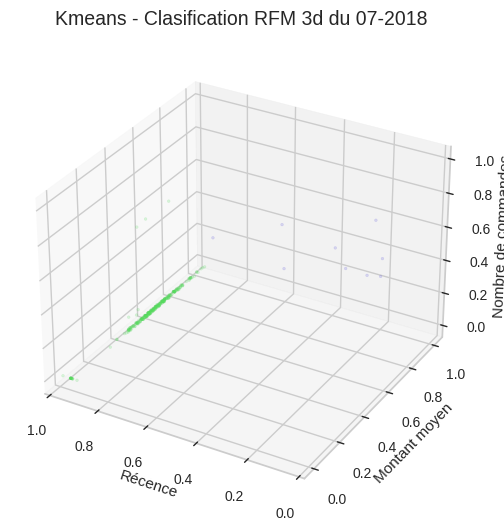

df2018_07 --> df2018_08
Score ARI : 1.0


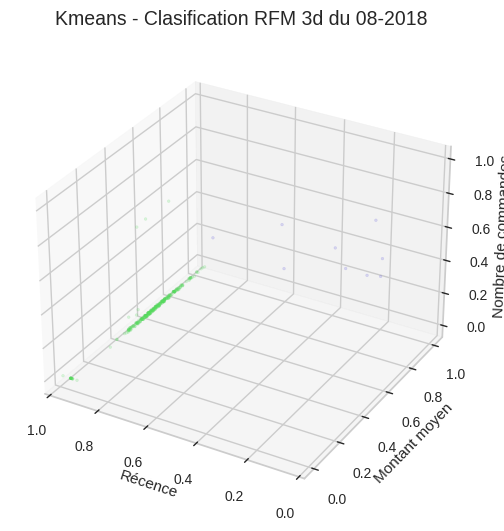

df2018_08 --> df2018_09
Score ARI : 1.0


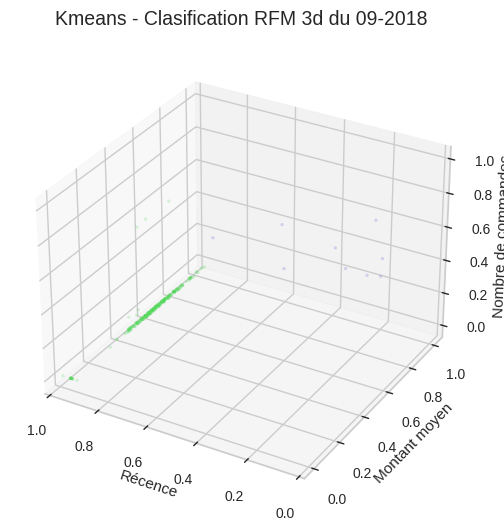

df2018_09 --> df2018_10
Score ARI : 1.0


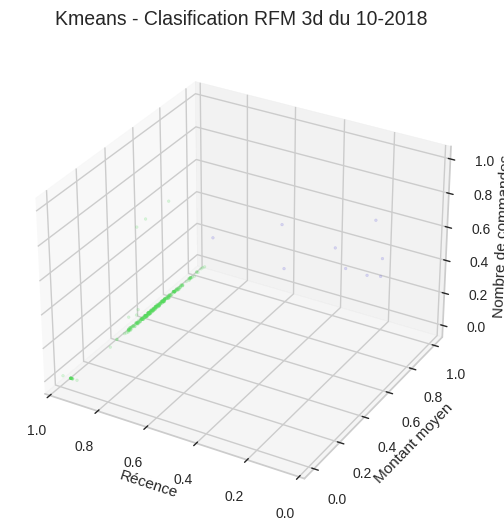

In [21]:
n=0
dfResult = pd.DataFrame()
for dfId in all_df:
    if dfId.startswith('df20'):
        n += 1
        if n > 1:
            dfResult=dfResult._append(getARI(modele, dfIdPrec, dfId),
                                      ignore_index=True)
        dfIdPrec = dfId

# Visualisation de l'ARI

In [22]:
dfResult

,Periode,ARI
0,2016_11,1.000000
1,2016_12,1.000000
2,2017_01,1.000000
3,2017_02,1.000000
4,2017_03,1.000000
5,2017_04,0.016101
6,2017_05,1.000000
7,2017_06,1.000000
8,2017_07,0.884532
9,2017_08,1.000000


In [23]:
# mise en forme pour graphe
dfResult['Periode'] = dfResult['Periode'].str.replace("_", "/")

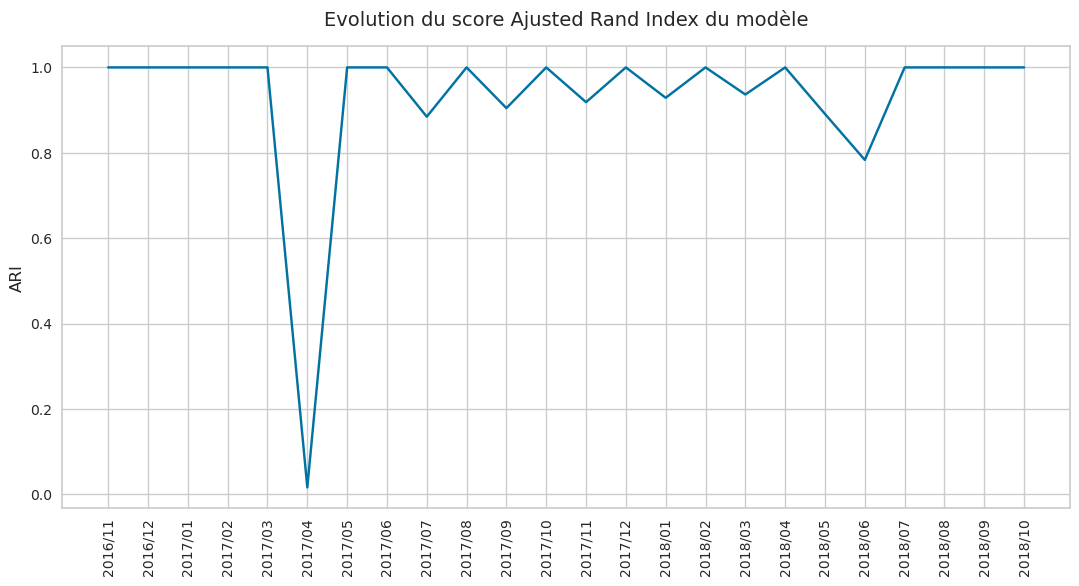

In [24]:
titre = "Evolution du score Ajusted Rand Index du modèle"
plt.figure(figsize=(13, 6))
plt.title(titre, fontsize=14)
sns.set_style("whitegrid")
plt.plot(dfResult['Periode'],dfResult['ARI'])
plt.title(titre, fontsize=14, pad=15)
plt.ylabel('ARI', fontsize=12)
plt.xticks(rotation=90)
plt.savefig(dossierImage+titre+'.jpg')
plt.show()

# Sauvegarde des DataFrames

In [25]:
# Sauvegarde des Df
def SaveDf(df2Save):
    print(f'sauvegarde dataFrame {df2Save} vers {dossierDatas}{df2Save}.csv')
    globals()[f'{df2Save}'].to_csv(f'{dossierDatas}{df2Save}.csv',
                                   index=False,
                                   sep='|',
                                   lineterminator='\n',
                                   encoding='utf-8')

all_df = %who_ls DataFrame
for dfItem in all_df:
    SaveDf(dfItem)


sauvegarde dataFrame df vers datas/df.csv
sauvegarde dataFrame df2016_10 vers datas/df2016_10.csv
sauvegarde dataFrame df2016_11 vers datas/df2016_11.csv
sauvegarde dataFrame df2016_12 vers datas/df2016_12.csv
sauvegarde dataFrame df2017_01 vers datas/df2017_01.csv
sauvegarde dataFrame df2017_02 vers datas/df2017_02.csv
sauvegarde dataFrame df2017_03 vers datas/df2017_03.csv
sauvegarde dataFrame df2017_04 vers datas/df2017_04.csv
sauvegarde dataFrame df2017_05 vers datas/df2017_05.csv
sauvegarde dataFrame df2017_06 vers datas/df2017_06.csv
sauvegarde dataFrame df2017_07 vers datas/df2017_07.csv
sauvegarde dataFrame df2017_08 vers datas/df2017_08.csv
sauvegarde dataFrame df2017_09 vers datas/df2017_09.csv
sauvegarde dataFrame df2017_10 vers datas/df2017_10.csv
sauvegarde dataFrame df2017_11 vers datas/df2017_11.csv
sauvegarde dataFrame df2017_12 vers datas/df2017_12.csv
sauvegarde dataFrame df2018_01 vers datas/df2018_01.csv
sauvegarde dataFrame df2018_02 vers datas/df2018_02.csv
sauveg